### 导入依赖库

In [10]:
# 导入依赖库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置中文字体（解决matplotlib中文显示问题）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

### 数据读取与初步整合

#### 1. 定义文件路径

In [14]:
# 定义4个街区的房价/租金文件路径（键：街区名，值：房价/租金文件名）
file_paths = {
    'Xisanqi': {'price': 'Xisanqi_Price.csv', 'rent': 'Xisanqi_Rent.csv'},
    'Xierqi': {'price': 'Xierqi_Price.csv', 'rent': 'Xierqi_Rent.csv'},
    'Shangdi': {'price': 'Shangdi_Price.csv', 'rent': 'Shangdi_Rent.csv'},
    'Qinghe': {'price': 'Qinghe_Price.csv', 'rent': 'Qinghe_Rent.csv'}
}

#### 2. 循环读取并整合数据

In [17]:
# 初始化空列表，存储所有街区的原始数据（仅标记类型，未计算衍生指标）
raw_data_list = []

for district, files in file_paths.items():
    # 1. 读取房价原始数据
    price_raw = pd.read_csv(files['price'], on_bad_lines='skip')    # skip：跳过格式错误行（如不完整数据）
    price_raw['data_type'] = 'house_price'    # 标记“房价”类型
    price_raw['location'] = district    # 确保“街区”列值正确（避免CSV中location列异常）
    
    # 2. 读取租金原始数据
    rent_raw = pd.read_csv(files['rent'], on_bad_lines='skip')
    rent_raw['data_type'] = 'house_rent'    # 标记“租金”类型
    rent_raw['location'] = district
    
    # 3. 合并当前街区的房价/租金原始数据，添加到总列表
    district_raw = pd.concat([price_raw, rent_raw], ignore_index=True)
    raw_data_list.append(district_raw)

# 合并所有原始数据为总DataFrame
raw_total_df = pd.concat(raw_data_list, ignore_index=True)

# 基础数据有效性检查：删除面积<=0或总价/租金<=0的明显错误数据（非IQR异常值，是逻辑错误）
invalid_idx = raw_total_df[(raw_total_df['m2'] <= 0) | (raw_total_df['price'] <= 0)].index
if len(invalid_idx) > 0:
    raw_total_df = raw_total_df.drop(invalid_idx)
    print(f"删除明显错误数据（面积/总价<=0）：{len(invalid_idx)}行")

print(f"原始数据读取完成：共{len(raw_total_df)}行，包含字段：{raw_total_df.columns.tolist()}")
print("\n原始数据前5行预览：")
print(raw_total_df[['m2', 'price', 'location', 'data_type']].head())

原始数据读取完成：共8042行，包含字段：['m2', 'price', 'location', 'data_type']

原始数据前5行预览：
       m2   price location    data_type
0  115.00   620.0  Xisanqi  house_price
1  139.00   860.0  Xisanqi  house_price
2  206.89  1638.0  Xisanqi  house_price
3  160.12  1169.0  Xisanqi  house_price
4   75.54   437.0  Xisanqi  house_price


### 处理基础数据异常值

#### 1. 定义基础数据异常值检测函数

In [21]:
def detect_basic_outliers(group_df, target_field, iqr_multiplier=1.5):
    """
    用IQR方法检测基础数据（面积或总价/租金）的异常值
    参数：
        group_df：按“街区+数据类型”分组后的DataFrame
        target_field：待检测的基础字段（'m2'表示面积，'price'表示总价/租金）
    返回：
        outliers_idx：异常值的索引列表
        lower_bound/upper_bound：异常值判定边界
    """
    # 计算四分位数和四分位距
    Q1 = group_df[target_field].quantile(0.25)
    Q3 = group_df[target_field].quantile(0.75)
    IQR = Q3 - Q1
    
    # 异常值边界（1.5×IQR是行业常用阈值，兼顾灵敏度和稳健性）
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    
    # 筛选异常值索引（排除边界外的数据）
    outliers_idx = group_df[(group_df[target_field] < lower_bound) | (group_df[target_field] > upper_bound)].index
    return outliers_idx, lower_bound, upper_bound

In [23]:
# 初始化基础数据处理后的列表
basic_cleaned_list = []

# 按“街区（location）+数据类型（data_type）”分组处理基础数据
for (district, data_type), group in raw_total_df.groupby(['location', 'data_type']):
    # 复制分组数据，避免修改原数据
    group_basic_clean = group.copy()
    initial_count = len(group_basic_clean)    # 处理前的行数
    
    # --------------------------
    # 第一步：处理“面积（m²）”异常值
    # --------------------------
    m2_outliers_idx, m2_lower, m2_upper = detect_basic_outliers(group_basic_clean, 'm2')
    if len(m2_outliers_idx) > 0:
        group_basic_clean = group_basic_clean.drop(m2_outliers_idx)
        print(f"\n{district} - {data_type}：")
        print(f"  面积异常值：删除{len(m2_outliers_idx)}行（面积范围：{m2_lower:.2f}~{m2_upper:.2f} m²）")
    
    # --------------------------
    # 第二步：处理“总价/租金（price）”异常值
    # --------------------------
    price_outliers_idx, price_lower, price_upper = detect_basic_outliers(group_basic_clean, 'price')
    if len(price_outliers_idx) > 0:
        group_basic_clean = group_basic_clean.drop(price_outliers_idx)
        print(f"  总价/租金异常值：删除{len(price_outliers_idx)}行（{data_type.replace('house_', '')}范围：{price_lower:.2f}~{price_upper:.2f}）")
    
    # 统计当前分组的处理结果
    final_count = len(group_basic_clean)
    deleted_count = initial_count - final_count
    if deleted_count > 0:
        print(f"  处理后剩余：{final_count}行（共删除{deleted_count}行）")
    else:
        print(f"\n{district} - {data_type}：未检测到基础数据异常值，保留{final_count}行")
    
    # 添加到处理后列表
    basic_cleaned_list.append(group_basic_clean)

# 合并所有基础数据处理后的结果
basic_cleaned_total_df = pd.concat(basic_cleaned_list, ignore_index=True)
print(f"\n基础数据异常值处理完成：")
print(f"  原始数据总行数（已删逻辑错误）：{len(raw_total_df)}")
print(f"  基础数据处理后总行数：{len(basic_cleaned_total_df)}")
print(f"  累计删除基础数据异常值：{len(raw_total_df) - len(basic_cleaned_total_df)}行")


Qinghe - house_price：
  面积异常值：删除35行（面积范围：-38.76~305.79 m²）
  处理后剩余：1165行（共删除35行）

Qinghe - house_rent：
  面积异常值：删除62行（面积范围：-15.50~164.50 m²）
  总价/租金异常值：删除103行（rent范围：1000.00~12200.00）
  处理后剩余：1035行（共删除165行）

Shangdi - house_price：
  面积异常值：删除14行（面积范围：-6.08~229.60 m²）
  总价/租金异常值：删除33行（price范围：99.38~1834.38）
  处理后剩余：1153行（共删除47行）

Shangdi - house_rent：
  面积异常值：删除9行（面积范围：-28.50~199.50 m²）
  总价/租金异常值：删除27行（rent范围：-1000.00~17400.00）
  处理后剩余：974行（共删除36行）

Xierqi - house_price：
  面积异常值：删除58行（面积范围：-3.93~233.43 m²）
  总价/租金异常值：删除2行（price范围：-437.50~1926.50）
  处理后剩余：634行（共删除60行）

Xierqi - house_rent：
  面积异常值：删除31行（面积范围：-45.62~245.38 m²）
  总价/租金异常值：删除19行（rent范围：-500.00~16300.00）
  处理后剩余：386行（共删除50行）

Xisanqi - house_price：
  面积异常值：删除65行（面积范围：-21.74~229.04 m²）
  总价/租金异常值：删除69行（price范围：-195.00~1257.00）
  处理后剩余：1066行（共删除134行）

Xisanqi - house_rent：
  面积异常值：删除115行（面积范围：-7.50~148.50 m²）
  总价/租金异常值：删除60行（rent范围：1450.00~9050.00）
  处理后剩余：927行（共删除175行）

基础数据异常值处理完成：
  原始数据总行数（已删逻辑错误）：8042
  基础数据处理后总行数：7340
 

### 基于清洁后的基础数据，计算每平米指标

In [26]:
# 复制基础数据处理后的结果，避免修改原数据
final_cleaned_df = basic_cleaned_total_df.copy()

# 按数据类型计算对应的“每平米指标”
# 1. 房价数据：计算“每平米房价（万元/m²，假设原price单位为万元，若为元可调整）”
final_cleaned_df.loc[final_cleaned_df['data_type'] == 'house_price', 'price_per_m2'] = (
    final_cleaned_df[final_cleaned_df['data_type'] == 'house_price']['price'] 
    / final_cleaned_df[final_cleaned_df['data_type'] == 'house_price']['m2']
)

# 2. 租金数据：计算“每平米租金（元/m²/月，假设原price单位为元/月）”
final_cleaned_df.loc[final_cleaned_df['data_type'] == 'house_rent', 'rent_per_m2'] = (
    final_cleaned_df[final_cleaned_df['data_type'] == 'house_rent']['price'] 
    / final_cleaned_df[final_cleaned_df['data_type'] == 'house_rent']['m2']
)

# 查看计算后的结果（重点看新增的每平米指标）
print("\n计算每平米指标后的 dataFrame 前5行（房价数据）：")
price_sample = final_cleaned_df[final_cleaned_df['data_type'] == 'house_price'][['m2', 'price', 'location', 'price_per_m2']].head()
print(price_sample.round(2))    # 保留2位小数，提升可读性

print("\n计算每平米指标后的 dataFrame 前5行（租金数据）：")
rent_sample = final_cleaned_df[final_cleaned_df['data_type'] == 'house_rent'][['m2', 'price', 'location', 'rent_per_m2']].head()
print(rent_sample.round(2))


计算每平米指标后的 dataFrame 前5行（房价数据）：
       m2   price location  price_per_m2
0  125.54  1265.0   Qinghe         10.08
1  166.00  1195.0   Qinghe          7.20
2  180.00  1450.0   Qinghe          8.06
3   97.68  1098.0   Qinghe         11.24
4  237.70  2800.0   Qinghe         11.78

计算每平米指标后的 dataFrame 前5行（租金数据）：
        m2   price location  rent_per_m2
1165  12.0  1700.0   Qinghe       141.67
1166  85.0  6600.0   Qinghe        77.65
1167  15.0  2350.0   Qinghe       156.67
1168  40.0  5000.0   Qinghe       125.00
1169  18.0  2000.0   Qinghe       111.11


In [28]:
# 按街区分组，对关键数值列进行描述统计
desc_stats = final_cleaned_df.groupby('location')[['m2', 'price', 'price_per_m2', 'rent_per_m2']].describe()

# 保留2位小数，提升可读性
desc_stats = desc_stats.round(2)

# 输出描述统计结果
print("\n各街区数据描述统计（处理异常值后）：")
print(desc_stats)

# （可选）将描述统计结果保存为Excel，方便后续报告使用
desc_stats.to_excel('各街区数据描述统计(1.5).xlsx')


各街区数据描述统计（处理异常值后）：
              m2                                                    price  \
           count    mean    std  min   25%    50%     75%     max   count   
location                                                                    
Qinghe    2200.0  101.30  55.60  7.0  60.0  88.23  139.00  286.31  2200.0   
Shangdi   2127.0   95.54  39.36  6.0  61.0  95.32  124.50  213.16  2127.0   
Xierqi    1020.0   99.34  43.07  8.0  69.0  91.70  126.08  231.39  1020.0   
Xisanqi   1993.0   81.37  36.11  8.0  61.0  82.00   93.56  195.53  1993.0   

                   ... price_per_m2        rent_per_m2                        \
             mean  ...          75%    max       count    mean    std    min   
location           ...                                                         
Qinghe    3640.96  ...        11.82  17.65      1035.0  104.19  37.20  15.62   
Shangdi   4123.17  ...        10.45  17.55       974.0  106.36  31.84  18.33   
Xierqi    3285.53  ...         8.19  12.

### 计算中位数租售比

In [31]:
# 1. 拆分处理后的房价和租金数据
price_clean = final_cleaned_df[final_cleaned_df['data_type'] == 'house_price'][['location', 'price_per_m2']]
rent_clean = final_cleaned_df[final_cleaned_df['data_type'] == 'house_rent'][['location', 'rent_per_m2']]

# 2. 按街区计算中位数租售比
price_to_rent_ratio = {}
for district in file_paths.keys():
    # 获取当前街区的“每平米房价（中位数，单位：万元/㎡）”
    median_price_per_m2 = price_clean[price_clean['location'] == district]['price_per_m2'].median()
    # 转换为“元/㎡”
    median_price_per_m2_yuan = median_price_per_m2 * 10000
    # 获取当前街区的“每平米月租金（中位数，单位：元/㎡/月）”
    median_rent_per_m2 = rent_clean[rent_clean['location'] == district]['rent_per_m2'].median()
    
    # 计算中位数租售比（保留2位小数）
    ratio = round(median_price_per_m2_yuan / median_rent_per_m2, 2)
    price_to_rent_ratio[district] = ratio

# 转换为DataFrame，方便后续使用
ratio_df = pd.DataFrame(list(price_to_rent_ratio.items()), columns=['街区', '中位数租售比'])
print("\n各街区中位数租售比：")
print(ratio_df)


各街区中位数租售比：
        街区   中位数租售比
0  Xisanqi   696.57
1   Xierqi   667.06
2  Shangdi   827.66
3   Qinghe  1043.36


### 绘制中位数租售比柱状图

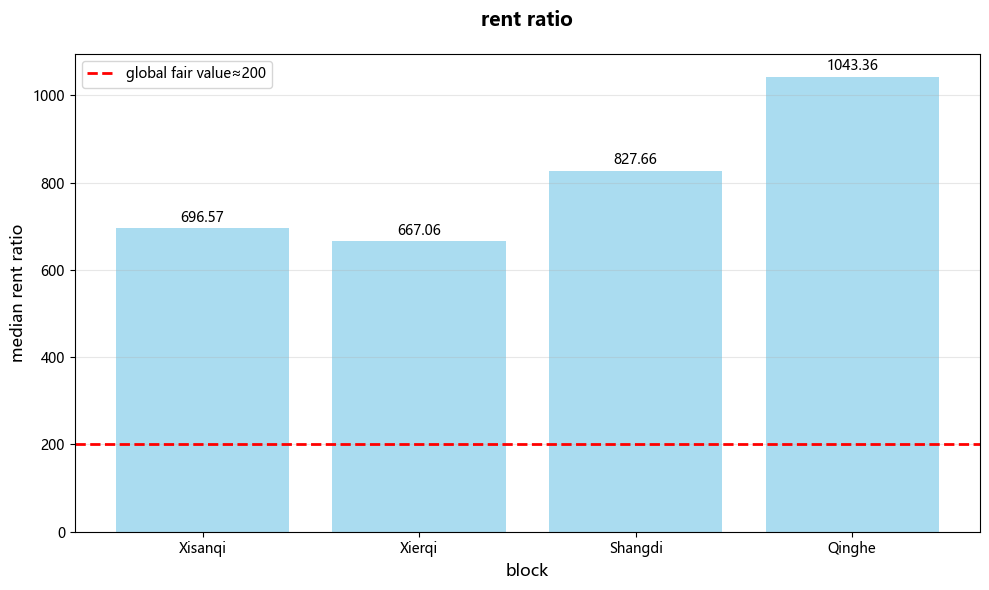

In [34]:
# 1. 创建画布与子图
fig, ax = plt.subplots(figsize=(10, 6))

# 2. 绘制柱状图
districts = ratio_df['街区']
ratios = ratio_df['中位数租售比']
bars = ax.bar(districts, ratios, color=['skyblue'], alpha=0.7)

# 3. 添加全球公允值水平线（红色虚线）
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='global fair value≈200')

# 4. 设置图表样式（标题、轴标签、图例等）
ax.set_title('rent ratio', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('block', fontsize=12)
ax.set_ylabel('median rent ratio', fontsize=12)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)  # 添加水平网格线，方便读数

# 5. 在柱子上标注具体数值
for bar, ratio in zip(bars, ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{ratio}', ha='center', va='bottom', fontsize=10)

# 6. 调整布局并保存图片（可保存为png格式，方便插入报告）
plt.tight_layout()
plt.savefig('四街区中位数租售比柱状图.png', dpi=300, bbox_inches='tight')
plt.show()

### 保存清洗后的数据

In [37]:
# 1. 定义保存文件夹名称和路径
save_folder = "Cleaned_data"    # 文件夹名（可自定义，如“四街区清洁数据”）
current_path = os.getcwd()    # 获取当前Jupyter文件的所在路径
save_full_path = os.path.join(current_path, save_folder)    # 拼接完整保存路径

# 2. 创建文件夹（exist_ok=True：若文件夹已存在，不报错）
os.makedirs(save_full_path, exist_ok=True)
print(f"数据保存文件夹已创建/确认：{save_full_path}")

数据保存文件夹已创建/确认：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data


In [41]:
# 获取所有唯一的街区名称
districts = final_cleaned_df["location"].unique()

for district in districts:
    # 提取当前街区的所有数据
    district_data = final_cleaned_df[final_cleaned_df["location"] == district].copy()
    
    # 按“数据类型（房价/租金）”分别处理
    for data_type in ["house_price", "house_rent"]:
        # 筛选当前数据类型的子集（仅房价或仅租金）
        type_data = district_data[district_data["data_type"] == data_type].copy()
        
        # 过滤不需要的列：房价文件删 rent_per_m2，租金文件删 price_per_m2
        if data_type == "house_price":
            type_data = type_data.drop(columns=["rent_per_m2"], errors="ignore")    # 列不存在时不报错
        else:  # data_type == "house_rent"
            type_data = type_data.drop(columns=["price_per_m2"], errors="ignore")
        
        # 定义保存文件名（格式：街区名_数据类型_cleaned.csv）
        save_filename = f"{district}_{data_type}_cleaned.csv"
        save_filepath = os.path.join(save_full_path, save_filename)
        
        # 保存为CSV（index=False：不保存行号；utf-8-sig：兼容Excel中文）
        type_data.to_csv(save_filepath, index=False, encoding="utf-8-sig")
        
        # 打印保存信息，确认成功
        print(f"{district} - {data_type} 数据已保存：{save_filepath}")
        print(f"   - 数据行数：{len(type_data)} 行")
        print(f"   - 包含列：{type_data.columns.tolist()}\n")

Qinghe - house_price 数据已保存：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data\Qinghe_house_price_cleaned.csv
   - 数据行数：1165 行
   - 包含列：['m2', 'price', 'location', 'data_type', 'price_per_m2']

Qinghe - house_rent 数据已保存：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data\Qinghe_house_rent_cleaned.csv
   - 数据行数：1035 行
   - 包含列：['m2', 'price', 'location', 'data_type', 'rent_per_m2']

Shangdi - house_price 数据已保存：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data\Shangdi_house_price_cleaned.csv
   - 数据行数：1153 行
   - 包含列：['m2', 'price', 'location', 'data_type', 'price_per_m2']

Shangdi - house_rent 数据已保存：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data\Shangdi_house_rent_cleaned.csv
   - 数据行数：974 行
   - 包含列：['m2', 'price', 'location', 'data_type', 'rent_per_m2']

Xierqi - house_price 数据已保存：D:\大学学习\大三上\人工智能与python （量化）\作业代码\homework_3\HW3_My_Data_My_Model\Cleaned_data\Xierqi_house_

### Comments:

- 按“街区+数据类型（房价/租金）”将数据分为8组（4个街区各对应房价、租金组），采用IQR法检测并删除异常值：先计算每组数据的第一四分位数（Q1）、第三四分位数（Q3）与四分位距（\( IQR = Q3 - Q1 \)），将超出\( [Q1 - 1.5 \times IQR, Q3 + 1.5 \times IQR] \)范围的数据判定为异常值并删除。
- 清河：房价删除35条面积异常值，剩余1165行；租金删除62条面积异常值和103条租金异常值，剩余1035行。
- 上地：房价删除14条面积异常值和33条价格异常值，剩余1153行；租金删除9条面积异常值和27条租金异常值，剩余974行。
- 西二旗：房价删除58条面积异常值和2条价格异常值，剩余634行；租金删除31条面积异常值和19条租金异常值，剩余386行。
- 西三旗：房价删除65条面积异常值和69条价格异常值，剩余1066行；租金删除115条面积异常值和60条租金异常值，剩余927行。
- 原始有效数据共8042行，处理后剩余7340行，累计删除702条异常值。

- 尽管删除了部分异常值，各街区租售比均高于全球公允值，反映区域楼市特点与合理区间有差距。